# Optical Flow Functions
In this notebook, we're going to define the functions we will need for the display, calculations, GIF creation and other utilities that are useful (these functions were previously defined in v_Motion_Estimation but we moved them here to avoid circular dependencies).

## Importing necessary libraries and notebooks

In [36]:
import xarray as xr
import io
import os
import cv2
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from matplotlib import ticker
from IPython.display import Image, display
from PIL import Image as PILImage
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Import the other notebooks without running their cells
from ii_Data_Manipulation import visualize_4
from iii_GOES_average import time_list, visualize_aggregate, calculate_median
from iv_Image_Processing import collect_times, crop_image, save_aggregate, binarize_image, bilateral_image, process_dates, process_directory

## Optical Flow Algorithms

### Farneback_flow

In [41]:
def farneback_flow(prev_img, next_img):
    """
    Returns:
    - flow : np.ndarray
        The computed flow image that will have the same size as `prev_img` and
        type CV_32FC2. Each element of the flow matrix will be a vector that
        indicates the displacement (in pixels) of the corresponding pixel from
        the first image to the second image.

    Method Parameters:
    - flow : np.ndarray
        Optional input flow estimate. It must be a single precision floating point
        image with the same size as `prev_img`. If provided, the function uses it as
        an initial approximation of the flow. If None, the function estimates the flow
        from scratch.
    - pyr_scale : float
        The image scale (<1) to build pyramids for each image; pyr_scale=0.5
        means a classical pyramid, where each next layer is twice smaller than
        the previous one.
    - levels : int
        The number of pyramid layers including the initial image. Levels=1
        means that no extra layers are created and only the original images are used.
    - winsize : int
        The size of the window used to smooth derivatives used as a basis
        for the polynomial expansion. The larger the size, the smoother the
        input image and the more robust the algorithm is to noise, but the more
        blurred motion details become.
    - iterations : int
        The number of iterations the algorithm will perform at each pyramid level.
        More iterations can improve the accuracy of the flow estimation.
    - poly_n : int
        The size of the pixel neighborhood used to find polynomial expansion
        in each pixel. Typical values are 5 or 7.
    - poly_sigma : float
        The standard deviation of the Gaussian that is used to smooth derivatives
        used as a basis for the polynomial expansion. This parameter can
        typically be ~1.1 for poly_n=5 and ~1.5 for poly_n=7.
    - flags : int
        Operation flags that can specify extra options such as using the initial
        flow estimates or applying a more sophisticated form of smoothing:
        - cv2.OPTFLOW_USE_INITIAL_FLOW: Uses the input flow as an initial flow estimate.
        - cv2.OPTFLOW_FARNEBACK_GAUSSIAN: Uses a Gaussian window for smoothing
          derivatives instead of a box filter.
    """
    # Make images grayscale
    prev_img = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    next_img = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_img, next_img, flow = None, pyr_scale=0.5, levels=3, winsize=15, 
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0
    )
    return flow

### Lucas-Kanade

In [12]:
def LK_flow(prev_img, next_img):
    """
    Returns:
        new_points (np.ndarray): The points in the second image.
        status (np.ndarray): Array of statuses for each point.
        err (np.ndarray): Error for each point.
    """
    # Ensure images are grayscale
    if len(prev_img.shape) == 3:
        prev_img = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    if len(next_img.shape) == 3:
        next_img = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
    
    # Parameters for ShiTomasi corner detection
    feature_params = {'maxCorners': 100,
                      'qualityLevel': 0.3,
                      'minDistance': 7,
                      'blockSize': 7}

    # Parameters for Lucas-Kanade optical flow
    lk_params = {'winSize': (15, 15),
                 'maxLevel': 2,
                 'criteria': (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)}

    # Find good features to track (Shi-Tomasi corner detector)
    p0 = cv2.goodFeaturesToTrack(prev_img, mask=None, **feature_params)
    
    # Calculate optical flow (Lucas-Kanade)
    if p0 is not None:
        p1, st, err = cv2.calcOpticalFlowPyrLK(prev_img, next_img, p0, None, **lk_params)
        return p0, p1, st, err
    else:
        return None, None, None, None

## Useful Functions

### compute_flow_components
Computes the magnitude and angle of the optical flow from the given flow vector components and then visualizes them 

In [25]:
def compute_flow_components(flow):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=False)
    return mag, ang

### visualize_flow_components
Visualizes the magnitude and angle of optical flow using matplotlib.

In [27]:
def visualize_flow_components(mag, ang):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Magnitude plot
    ax[0].imshow(mag, cmap='hot')
    ax[0].set_title('Optical Flow Magnitude')
    ax[0].axis('off')

    # Angle plot
    # Normalize the angles between 0 and 1 for visualization
    ang_normalized = ang / (2 * np.pi)
    ax[1].imshow(ang_normalized, cmap='hsv')  # HSV colormap to represent angle
    ax[1].set_title('Optical Flow Angle')
    ax[1].axis('off')

    plt.show()

### plot_of_vectors
We can also visualize the motion field through vectors. This uses quiver from matplotlib.

Quiver produces nice looking arrows, but for our purposes, overlay_flow_vectors is probably better.

In [68]:
def plot_of_vectors(flow, base_img, step=16, scale=1, display=True, color='r'):
    """
    Creates a plot of optical flow vectors over the base image and optionally displays it.

    :param flow: Computed flow vectors with shape (H, W, 2).
    :param base_img: Base image on which to plot the vectors.
    :param step: Grid step size for sampling vectors. Smaller values increase density.
    :param scale: Scaling factor for the magnitude of vectors to enhance visibility.
    :param display: Boolean indicating whether to display the plot.
    :return: An image array of the plot.
    """
    H, W = flow.shape[:2]
    y, x = np.mgrid[0:H:step, 0:W:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(base_img, cmap='gray')  # Ensure the image is displayed correctly
    ax.quiver(x, y, fx, fy, color=color, angles='xy', scale_units='xy', scale=1/scale, width=0.0025)
    ax.set_xlim([0, W])
    ax.set_ylim([H, 0])
    ax.axis('off')  # Turn off the axis

    # Optionally display the plot
    if display:
        plt.show()

    # Convert the Matplotlib figure to a PIL Image and then to a NumPy array
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)  # Close the figure to free memory
    buf.seek(0)
    img = PILImage.open(buf)
    img_arr = np.array(img)

    return img_arr

In [63]:
# if __name__ == '__main__':
#     prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
#     next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
#     flow = farneback_flow(prev_img, next_img)
#     plot_of_vectors(flow, prev_img, step=16, scale=1.25)
#     display(Image(filename="/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png", width =750))

### overlay_flow_vectors
Overlays optical flow vectors on an image and returns the resulting image with vectors. Uses arrowedLine from OpenCV.

In [32]:
def overlay_flow_vectors(flow, base_img, step=16, scale=1, color=(255, 0, 0)):
    # Ensure base_img is in RGB to display colored vectors
    if len(base_img.shape) == 2:
        base_img = cv2.cvtColor(base_img, cv2.COLOR_GRAY2RGB)
    
    H, W = flow.shape[:2]
    y, x = np.mgrid[0:H:step, 0:W:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T

    # Create a figure for drawing
    result_img = np.copy(base_img)
    for i in range(len(x)):
        start_point = (x[i], y[i])
        end_point = (int(x[i] + fx[i] * scale), int(y[i] + fy[i] * scale))
        cv2.arrowedLine(result_img, start_point, end_point, color, 1, tipLength=0.3)

    return result_img

### overlay_flow_vectors_with_quiver

In [96]:
def overlay_flow_vectors_with_quiver(flow, base_img, step=16, scale=1, color='r'):
    """
    Overlays flow vectors using matplotlib's quiver directly on the image,
    ensuring that the quiver plot matches the image size and aspect ratio.
    """
    if len(base_img.shape) == 2:
        base_img = cv2.cvtColor(base_img, cv2.COLOR_GRAY2RGB)

    H, W = base_img.shape[:2]  # Use image dimensions for scaling and grid generation
    y, x = np.mgrid[0:H:step, 0:W:step].reshape(2, -1)
    fx, fy = flow[y, x].T

    fig, ax = plt.subplots(figsize=(W / 100, H / 100), dpi=100)  # Set figure size based on image dimensions
    ax.imshow(base_img, extent=[0, W, H, 0], aspect='auto')  # Force aspect ratio to match the image
    ax.quiver(x, y, fx, fy, color=color, angles='xy', scale_units='xy', scale=1/scale, width=0.002)
    ax.set_xlim([0, W])
    ax.set_ylim([H, 0])
    ax.axis('off')

    # Convert figure to an image
    canvas = FigureCanvas(fig)
    canvas.draw()
    img_rgba = np.frombuffer(canvas.tostring_argb(), dtype=np.uint8)
    img = img_rgba.reshape(canvas.get_width_height()[::-1] + (4,))[..., :3]  # Convert ARGB to RGB

    plt.close(fig)
    return img

### create_flow_gif
We can try to visualize the result using a GIF.

In [94]:
def create_flow_gif(images, gif_path, fps=1, loop=10, quiver=False):
    """
    Creates a GIF from a sequence of images, calculating optical flow and overlaying vectors.
    """
    images_for_gif = []
    
    for i in range(len(images) - 1):
        prev_img = images[i]
        next_img = images[i+1]
        flow = farneback_flow(prev_img, next_img)  # Assumes existence of this function
        
        if quiver:
            overlay_img = overlay_flow_vectors_with_quiver(flow, prev_img)
        else:
            overlay_img = overlay_flow_vectors(flow, prev_img)  # Assumes existence of this function
        
        images_for_gif.append(prev_img)  # Add original image
        images_for_gif.append(overlay_img)  # Add image with vectors

    # Add the last image to the gif
    images_for_gif.append(images[-1])

    # Write GIF
    imageio.mimsave(gif_path, images_for_gif, fps=fps, loop=loop)

In [97]:
# if __name__ == '__main__':
#     # Saving the GIF
#     prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
#     next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
#     images = [prev_img, next_img]
#     create_flow_gif(images, '/home/yahia/Documents/Jupyter/Sargassum/Images/GIFs/optical_flow.gif', fps=0.2, loop=10, quiver=True)
    
#     # Displaying the GIF
#     gif_path = '/home/yahia/Documents/Jupyter/Sargassum/Images/GIFs/optical_flow.gif' 
#     display(Image(filename=gif_path))

### LK_vector_field
This function doesn't plot the image directly but returns it instead.

In [15]:
def LK_vector_field(p0, p1, status, prev_img):
    """
    Creates an image with vectors plotted over the input image.
    
    Args:
    - p0: Initial points in the first image.
    - p1: Corresponding points in the second image.
    - status: Status array from optical flow indicating which points are valid.
    - prev_img: The first image on which vectors are drawn.
    
    Returns:
    - An image array with vectors drawn.
    """
    # Create a figure to draw the vectors
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(prev_img, cmap='gray')
    for i, (new, old) in enumerate(zip(p1, p0)):
        #if status[i]:
        a, b = new.ravel()
        c, d = old.ravel()
        ax.arrow(c, d, (a - c), (b - d), color='red', head_width=2, head_length=3, linewidth=1.5, length_includes_head=True)
    
    ax.axis('off')
    
    # Save the plot to a buffer instead of showing it
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    
    # Load the image from the buffer
    img_array = np.array(PILImage.open(buf))
    
    return img_array

### display_image_cv

In [16]:
def display_image_cv(image_array):
    # OpenCV might load images in BGR format, ensure to convert to RGB if necessary
    if image_array.shape[2] == 3:  # Color image
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    cv2.imshow('Optical Flow Vectors', image_array)
    while True:
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [17]:
# if __name__ == '__main__':
#     # Binary image
#     prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
#     next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
#     p0, p1, st, err = LK_flow(prev_img, next_img)
#     img_with_vectors = LK_vector_field(p0, p1, st, prev_img)
#     display_image_cv(img_with_vectors)

### display_image_mpl

In [55]:
def display_image_mpl(image_array, scale=1):
    """
    Displays an image using matplotlib. Converts from BGR to RGB if needed and handles both grayscale and color images.
    Allows specification of the display size.

    Parameters:
    - image_array (numpy array): The image data array. It can be in grayscale or BGR color format.
    - width (float): Width of the figure in inches.
    - height (float): Height of the figure in inches.
    """
    # Check if image is in color (BGR format), and convert to RGB for display
    if len(image_array.shape) == 3 and image_array.shape[2] == 3:
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

    # Create a figure with specified size
    plt.figure(figsize=(8*scale, 6*scale))
    
    # Determine if the image is grayscale and display it
    if len(image_array.shape) == 2 or image_array.shape[2] == 1:
        plt.imshow(image_array, cmap='gray')  # Display grayscale image
    else:
        plt.imshow(image_array)  # Display color image
    
    # Hide axes and show the figure
    plt.axis('off')
    plt.show()

### superpose_images
This is a function that takes two images (preferably binarized for clarity) and superposes them on top of each other with different colors.

In [10]:
def superpose_images(image1, image2, color1=(255, 0, 0), color2=(0, 255, 0)):
    """
    Superposes the black regions of two binarized images onto a white background with different colors.
    Black areas from image1 and image2 are shown in distinct colors, and the background remains white.

    Parameters:
    - image1 (numpy.ndarray): The first binarized image, white background with black algae.
    - image2 (numpy.ndarray): The second binarized image, white background with black algae.
    - color1 (tuple): RGB color for the algae in the first image.
    - color2 (tuple): RGB color for the algae in the second image.

    Returns:
    - numpy.ndarray: An image with the black regions of the two input images superposed in the specified colors.
    """
    # Ensure images are grayscale
    if len(image1.shape) == 3:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    if len(image2.shape) == 3:
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Threshold images to ensure they are binary
    _, image1 = cv2.threshold(image1, 127, 255, cv2.THRESH_BINARY)
    _, image2 = cv2.threshold(image2, 127, 255, cv2.THRESH_BINARY)

    # Create a white RGB image with the same dimensions as the input images
    height, width = image1.shape
    colored_image = np.full((height, width, 3), fill_value=(255, 255, 255), dtype=np.uint8)  # White background

    # Apply the specified colors to the black regions of each binary image
    colored_image[(image1 == 0)] = color1  # Apply color1 where image1 is black
    colored_image[(image2 == 0)] = color2  # Apply color2 where image2 is black

    return colored_image

In [19]:
# if __name__ == '__main__':
#     prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
#     next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
#     superposed = superpose_images(prev_img, next_img)
#     display_image_cv(superposed)

In [ ]:
# if __name__ == '__main__':
#     motion_field = overlay_optical_flow_vectors(flow, superposed, step=16, scale=1, color=(0,0,255))
#     display_image_cv(motion_field)

### warp_image

In [109]:
def warp_image(img, flow):
    """
    Warps an image using the given optical flow map.

    Parameters:
    - img (numpy.ndarray): The original image to be warped.
    - flow (numpy.ndarray): The optical flow vectors that indicate pixel displacements.

    Returns:
    - warped_img (numpy.ndarray): The resulting image after applying the flow warp.
    """
    h, w = img.shape[:2]
    # Create grid of coordinates
    flow_map = np.column_stack((np.indices((h, w))[1].ravel() + flow[..., 0].ravel(),  # x coordinates
                                np.indices((h, w))[0].ravel() + flow[..., 1].ravel())) # y coordinates
    # Map coordinates from flow
    flow_map = flow_map.reshape(h, w, 2).astype(np.float32)
    # Apply remapping
    warped_img = cv2.remap(img, flow_map, None, cv2.INTER_LANCZOS4)

    return warped_img

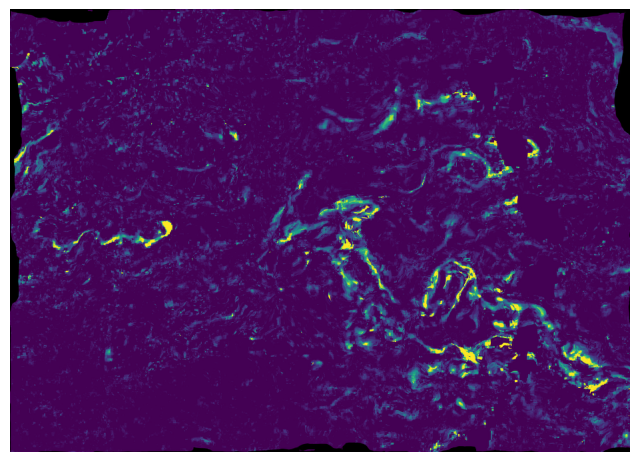

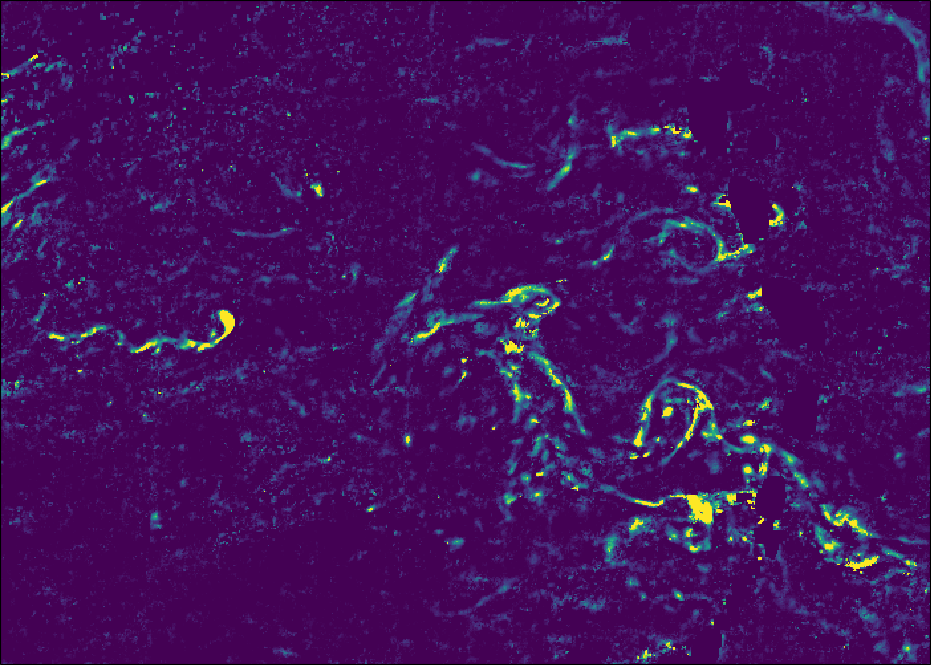

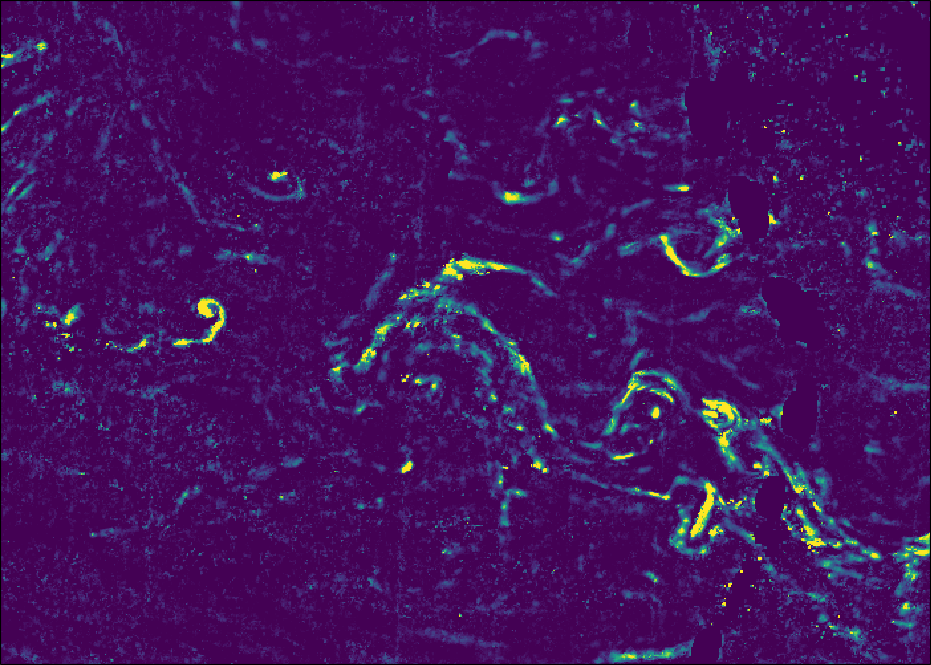

In [110]:
if __name__ == '__main__':
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback_flow(prev_img, next_img)
    #plot_of_vectors(flow, prev_img, step=16, scale=1.25)
    warped = warp_image(prev_img, flow)
    display_image_mpl(warped)
    display(Image(filename="/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png", width =750))
    display(Image(filename="/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png", width =750))

## Error Quantification

### calculate_mse

In [114]:
def calculate_mse(image1, image2):
    """
    Calculates the Mean Squared Error between two images, which measures the average of the squares of the errors.
    
    Parameters:
    - image1 (numpy.ndarray): The first image (e.g., warped image).
    - image2 (numpy.ndarray): The second image (e.g., actual next frame).

    Returns:
    - float: The mean squared error between the two images.
    """
    # Ensure the images are the same shape
    assert image1.shape == image2.shape, "Images must have the same dimensions."

    # Compute the squared differences
    diff = np.square(image1.astype("float") - image2.astype("float"))
    
    # Return the mean of the differences
    mse = np.mean(diff)
    return mse

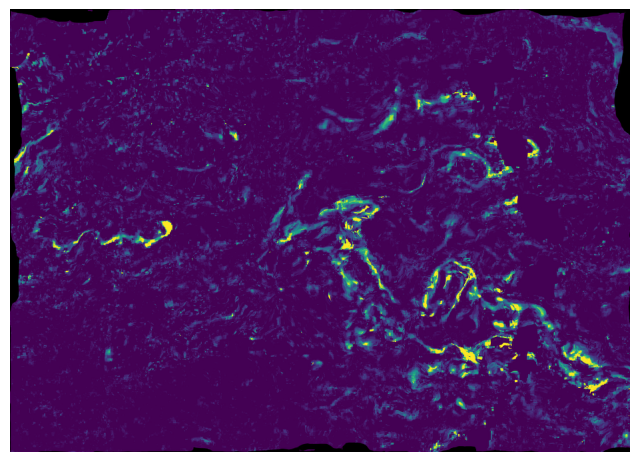

MSE = 1066.1935327039403


In [123]:
if __name__ == '__main__':
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback_flow(prev_img, next_img)
    #plot_of_vectors(flow, prev_img, step=16, scale=1.25)
    warped = warp_image(prev_img, flow)
    display_image_mpl(warped)
    print("MSE = " + str(calculate_mse(warped, next_img)))